In [6]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

df = pd.read_csv('hpv_prevalence.csv')
df['age_group'] = np.floor(df.age/10 - 30/10) # 10 year age groups
df['age_group'] = np.where(df.age_group < 3, df.age_group, 3) # joining 70 year-olds with 60-70 group

In [12]:
import pymc as pm
import arviz as az

df["age_scaled"] = (df["age"] - df["age"].mean()) / df["age"].std()

with pm.Model() as model:

    # AGE → FIRST SEX
    a_fs_intercept = pm.Normal("a_fs_intercept", mu=12, sigma=2)
    a_fs_slope = pm.Normal("a_fs_slope", mu=0.5, sigma=1)
    a_smoke_intercept = pm.Normal("a_smoke_intercept", mu=-1, sigma=1)
    a_smoke_age = pm.Normal("a_smoke_age", mu=0.3, sigma=0.2)
    mu_first_sex = a_fs_intercept + a_fs_slope * df["age_scaled"]
    sigma_first_sex = pm.HalfNormal("sigma_first_sex", sigma=1)
    first_sex = pm.Normal("first_sex", mu=mu_first_sex, sigma=sigma_first_sex, observed=df["first_sex"])

    # Priors for hormonal contraceptives model
    a_hc_intercept = pm.Normal("a_hc_intercept", mu=2.9, sigma=1)
    a_hc_age = pm.Normal("a_hc_age", mu=-0.5, sigma=0.2)
    a_hc_fs = pm.Normal("a_hc_fs", mu=-0.1, sigma=0.1)
    a_hc_np = pm.Normal("a_hc_np", mu=0.05, sigma=0.05)

    # Priors for hrHPV model
    intercept = pm.Normal("intercept", mu=-2.5, sigma=1)
    b_hc = pm.Normal("beta_contraceptives", mu=0.5, sigma=0.3)
    b_smoke = pm.Normal("beta_smoking", mu=0.2, sigma=0.2)
    b_age = pm.Normal("beta_age", mu=0.0, sigma=0.3)
    b_age2 = pm.Normal("beta_age2", mu=0.0, sigma=0.3)
    b_np = pm.Normal("beta_n_partners", mu=0.03, sigma=0.02)

    # FIRST SEX + AGE → NR OF SEX PARTNERS
    mu_partners = (
        pm.Normal("a_np_intercept", mu=6, sigma=2)
        + pm.Normal("a_np_fs", mu=-0.3, sigma=0.2) * df["first_sex"]
        + pm.Normal("a_np_age", mu=-0.5, sigma=0.2) * df["age_scaled"])
    
    mu_partners_clip = pm.Deterministic("mu_partners_clip", pm.math.clip(mu_partners, 1, 10))
    nr_partners = pm.Poisson("nr_of_sex_partners", mu = mu_partners_clip, observed=df["nr_of_sex_partners"])

    # AGE → SMOKING
    p_smoke = a_smoke_intercept + a_smoke_age * df["age_scaled"]
    smoking = pm.Bernoulli("smoking", logit_p = p_smoke, observed=df["smoking"])
    

    # AGE + FIRST SEX + PARTNERS → CONTRACEPTIVES
    p_hc = (
    a_hc_intercept + a_hc_age * df["age_scaled"] +
    a_hc_fs * df["first_sex"] + a_hc_np * df["nr_of_sex_partners"])
    
    hc = pm.Bernoulli("hormonal_contrcptvs", logit_p = p_hc, observed=df["hormonal_contrcptvs"])

    # FINAL: hrHPV PREVALENCE
    p_hpv = (
    intercept +
    b_hc * df["hormonal_contrcptvs"] +
    b_smoke * df["smoking"] +
    b_age * df["age_scaled"] +
    b_age2 * df["age_scaled"]**2 +
    b_np * df["nr_of_sex_partners"])
    
    hrhpv = pm.Bernoulli("hrhpv_prevalence", logit_p=p_hpv, observed=df["hrhpv_prevalence"])

    # Sampling
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Summary
az.summary(idata, round_to=2)


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:01:52

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 113 seconds.
/home/shahla/my_project/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/shahla/my_project/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/shahla/my_project/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/shahla/my_project/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_fs_intercept,20.31,0.06,20.19,20.42,0.00,0.00,13553.84,5735.67,1.0
a_fs_slope,1.01,0.06,0.90,1.13,0.00,0.00,15153.67,5147.34,1.0
a_smoke_intercept,-1.84,0.09,-2.01,-1.67,0.00,0.00,15884.60,5856.01,1.0
a_smoke_age,-0.09,0.08,-0.25,0.06,0.00,0.00,14111.34,5041.33,1.0
a_hc_intercept,2.03,0.59,0.84,3.06,0.01,0.01,7269.29,5203.10,1.0
...,...,...,...,...,...,...,...,...,...
mu_partners_clip[995],7.82,0.16,7.51,8.11,0.00,0.00,11512.88,5802.94,1.0
mu_partners_clip[996],2.54,0.10,2.35,2.74,0.00,0.00,8867.73,7164.77,1.0
mu_partners_clip[997],7.03,0.13,6.79,7.25,0.00,0.00,11899.18,6484.16,1.0
mu_partners_clip[998],2.09,0.10,1.90,2.27,0.00,0.00,10164.52,7518.41,1.0


We can also add some plots to visualise, in my notebook somehow they did not show the plots.
Some plots similar in our lectures:

In [15]:
print(list(idata.posterior.data_vars))


['a_fs_intercept', 'a_fs_slope', 'a_smoke_intercept', 'a_smoke_age', 'a_hc_intercept', 'a_hc_age', 'a_hc_fs', 'a_hc_np', 'intercept', 'beta_contraceptives', 'beta_smoking', 'beta_age', 'beta_age2', 'beta_n_partners', 'a_np_intercept', 'a_np_fs', 'a_np_age', 'sigma_first_sex', 'mu_partners_clip']


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

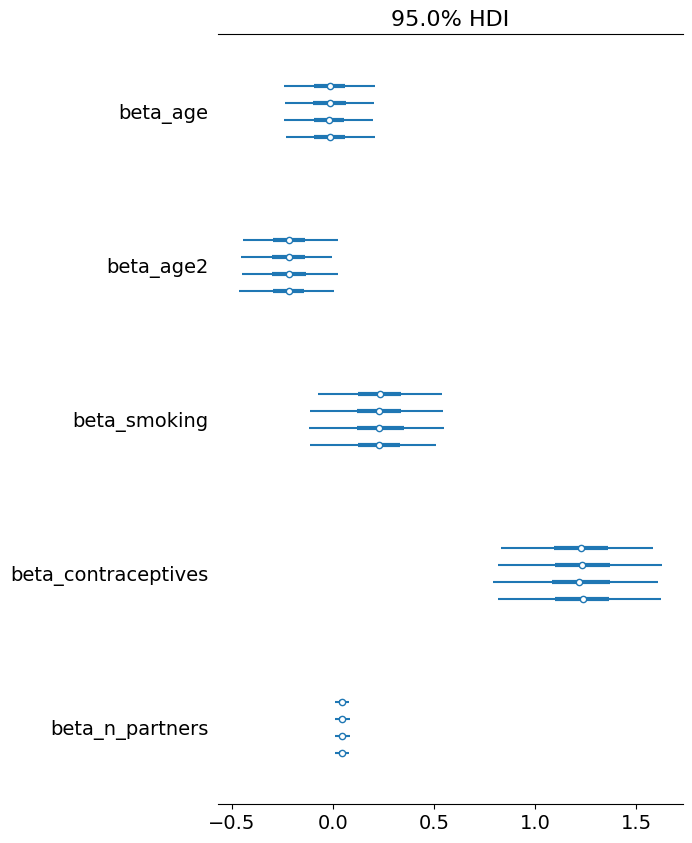

In [16]:
az.plot_forest(idata, var_names=["beta_age", "beta_age2", "beta_smoking", "beta_contraceptives", "beta_n_partners"], hdi_prob=0.95)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:04

array([[<Axes: xlabel='first_sex'>, <Axes: xlabel='nr_of_sex_partners'>,
        <Axes: xlabel='smoking'>],
       [<Axes: xlabel='hormonal_contrcptvs'>,
        <Axes: xlabel='hrhpv_prevalence'>, <Axes: >]], dtype=object)

/home/shahla/my_project/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/shahla/my_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


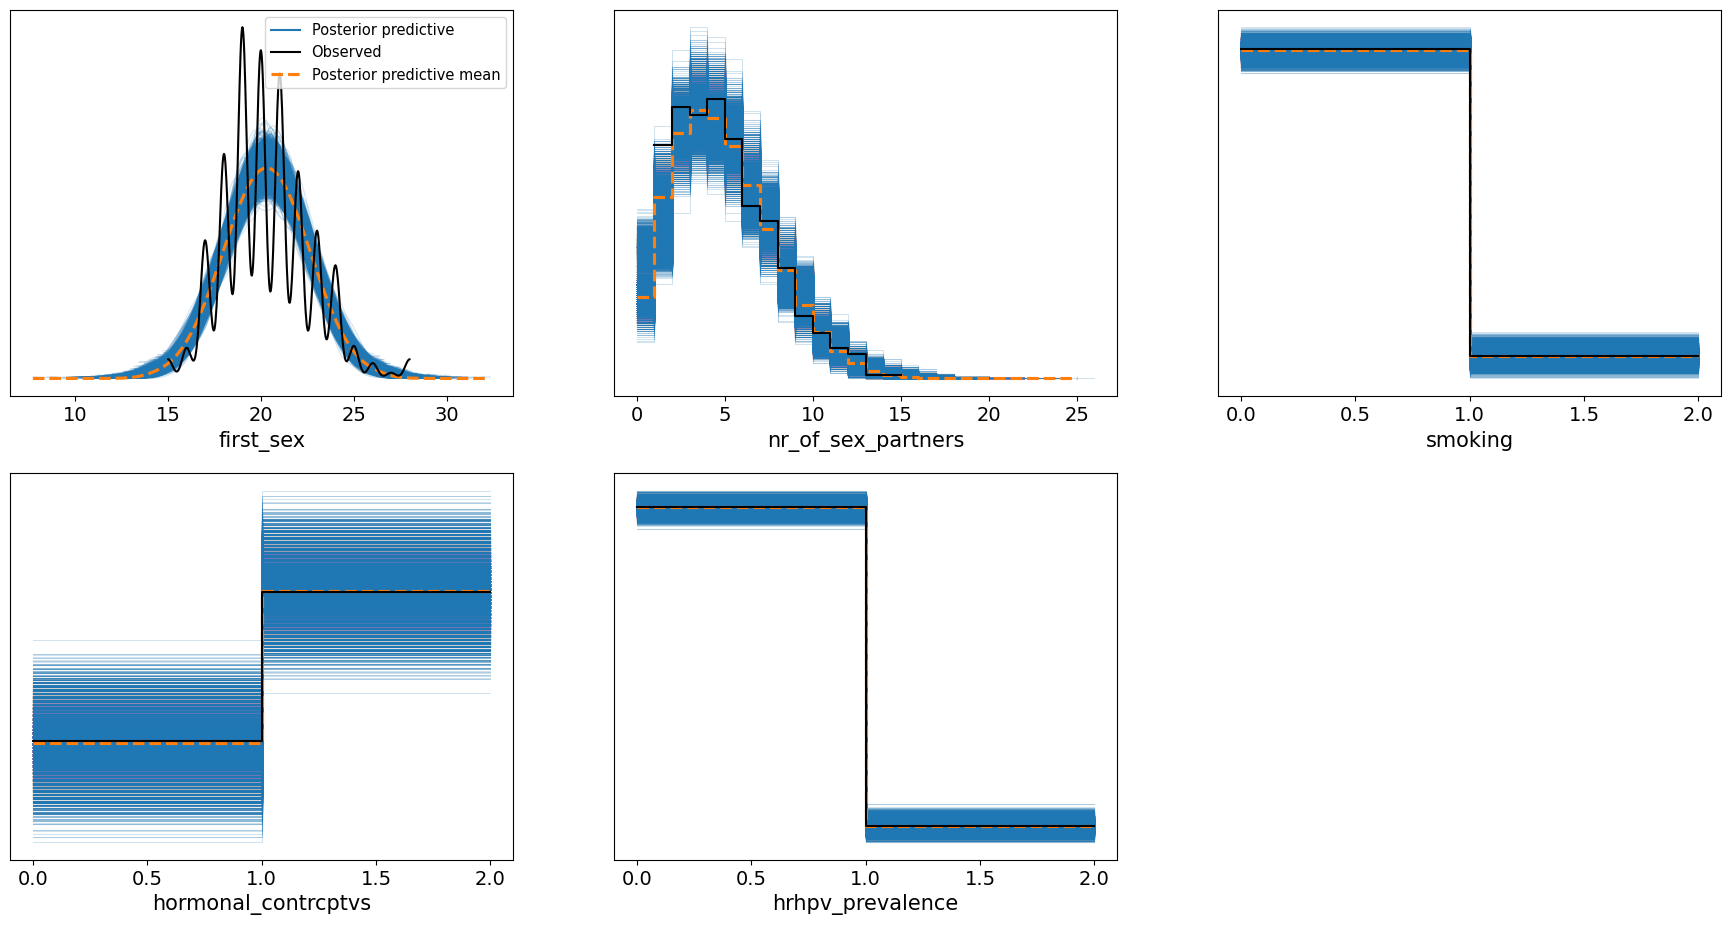

In [18]:
with model:
    ppc = pm.sample_posterior_predictive(idata)

az.plot_ppc(ppc, group="posterior", data_pairs={"hrhpv_prevalence": "hrhpv_prevalence"})
